Original implementation of Contrastive-sc method
(https://github.com/ciortanmadalina/contrastive-sc)

In [1]:
import sys
sys.path.append("..")
import argparse
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn import metrics

import torch
import torch.nn as nn
import copy
from tqdm.notebook import tqdm
import models
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import st_loss
import time
import h5py
import scipy as sp
import scanpy.api as sc
from collections import Counter
import random
import utils
import loop
import pickle

import train
import os
import glob2
plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/opt/conda/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
path = "../"
category = "real_data"
files = glob2.glob(f'{path}{category}/*.h5')
files = [f[len(f"'{path}{category}"):-3] for f in files]
files

['Quake_Smart-seq2_Trachea',
 'Quake_Smart-seq2_Diaphragm',
 'Quake_10x_Spleen',
 'Young',
 'mouse_ES_cell',
 'Adam',
 'Quake_10x_Bladder',
 'Quake_Smart-seq2_Lung',
 'Quake_10x_Limb_Muscle',
 'worm_neuron_cell',
 'mouse_bladder_cell',
 'Romanov',
 'Quake_Smart-seq2_Limb_Muscle',
 'Muraro',
 '10X_PBMC']

In [3]:
sczi = pd.read_pickle(f"../output/pickle_results/real_data/real_data_sczi.pkl")
# load the grid search result having the optimal nb of genes per dataset
optimal = pd.read_pickle(f"{path}output/pickle_results/real_data/optimal_input_size.pkl")
optimal.head()

,dataset,nb_genes
0,Quake_Smart-seq2_Trachea,500
1,Quake_Smart-seq2_Diaphragm,1000
2,Quake_10x_Spleen,500
3,Young,1000
4,mouse_ES_cell,1000


In [9]:
df = pd.DataFrame()
dropout = 0.9
lr = 0.4
layers = [200, 40, 60]
temperature = 0.07
for dataset in files:

    print(f">>>>> Data {dataset}")
    print("SCZI ", sczi[sczi["dataset"] == dataset]["ARI"].mean())
    data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
    X = np.array(data_mat['X'])
    Y = np.array(data_mat['Y'])

    cluster_number = np.unique(Y).shape[0]
    nb_genes = optimal[optimal["dataset"] == dataset]["nb_genes"].values[0]
    data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
    X = np.array(data_mat['X'])
    Y = np.array(data_mat['Y'])

    X = train.preprocess(X, nb_genes=nb_genes)

    for run in range(3):
        torch.manual_seed(run)
        torch.cuda.manual_seed_all(run)
        np.random.seed(run)
        random.seed(run)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        start = time.time()
        dresults = train.run(X,
                             cluster_number,
                             dataset,
                             Y=Y,
                             nb_epochs=30,
                             lr=lr,
                             temperature=temperature,
                             dropout=dropout,
                             evaluate=False,
                             layers=layers,
                             save_to=f"{path}output/{category}/{run}/",
                             save_pred = True)
        elapsed = time.time()-start
        dresults["temperature"] = temperature
        dresults["dropout"] = dropout
        dresults["nb_genes"] = nb_genes
        dresults["layers"] = str(layers)
        dresults["run"] = run
        dresults["time"] = elapsed
        dresults["t0"] = start
#         print(f".", end = "")
#         print(f"# {temperature}, {dropout}, {lr}, {layers}", 
#               dresults.get('COMBINED_kmeans_ari', ""),
#               dresults.get('COMBINED_leiden_ari', ""), dresults.get('kmeans_ari_0',""),
#               dresults.get('leiden_ari_0', ""))
        df = df.append(dresults, ignore_index=True)

        df.to_pickle(f"{path}output/pickle_results/{category}/{category}_baseline.pkl")

>>>>> Data Quake_Smart-seq2_Trachea
SCZI  0.8291128219663276
(1350, 23341) (1350, 23341) keeping 500 genes
>>>>> Data Quake_Smart-seq2_Diaphragm
SCZI  0.9596701189611787
(870, 23341) (870, 23341) keeping 1000 genes
>>>>> Data Quake_10x_Spleen
SCZI  0.909534824400645
(9552, 23341) (9552, 23341) keeping 500 genes
>>>>> Data Young
SCZI  0.6629811886776039
(5685, 33658) (5685, 33658) keeping 1000 genes
>>>>> Data mouse_ES_cell
SCZI  0.800376096099337
(2717, 24175) (2717, 24175) keeping 1000 genes
>>>>> Data Adam
SCZI  0.8634561030635544
(3660, 23797) (3660, 23797) keeping 500 genes
>>>>> Data Quake_10x_Bladder
SCZI  0.983095549108186
(2500, 23341) (2500, 23341) keeping 500 genes
>>>>> Data Quake_Smart-seq2_Lung
SCZI  0.7134055445020913
(1676, 23341) (1676, 23341) keeping 1000 genes
>>>>> Data Quake_10x_Limb_Muscle
SCZI  0.9610559204789085
(3909, 23341) (3909, 23341) keeping 500 genes
>>>>> Data worm_neuron_cell
SCZI  0.05077670288621814
(4186, 13488) (4186, 13488) keeping 5000 genes
>>>>> 

In [10]:
df.mean() #0.347519, # 0.499074# 0.520911

dropout         9.000000e-01
kmeans_ari_0    7.717891e-01
kmeans_nmi_0    8.052522e-01
kmeans_sil_0    5.983083e-01
leiden_ari_0    5.135286e-01
leiden_nmi_0    7.087917e-01
leiden_sil_0    3.971199e-01
nb_genes        1.066667e+03
run             1.000000e+00
t0              1.613068e+09
t1              1.613068e+09
t2              1.613068e+09
temperature     7.000000e-02
time            1.050582e+01
dtype: float64

# Train on cpu

In [13]:
df = pd.DataFrame()
dropout = 0.9
lr = 0.4
layers = [200, 40, 60]
temperature = 0.07
for dataset in files:

    print(f">>>>> Data {dataset}")
    print("SCZI ", sczi[sczi["dataset"] == dataset]["ARI"].mean())
    
    data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
    X = np.array(data_mat['X'])
    Y = np.array(data_mat['Y'])
    nb_genes = optimal[optimal["dataset"] == dataset]["nb_genes"].values[0]
    cluster_number = np.unique(Y).shape[0]
    X = train.preprocess(X, nb_genes=nb_genes)

    for run in range(3):
        torch.manual_seed(run)
        torch.cuda.manual_seed_all(run)
        np.random.seed(run)
        random.seed(run)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        start = time.time()
        dresults = train.run(X,
                             cluster_number,
                             dataset,
                             Y=Y,
                             nb_epochs=30,
                             lr=lr,
                             temperature=temperature,
                             dropout=dropout,
                             evaluate=False,
                             layers=layers,
                             save_to=f"{path}output/{category}/{run}/",
                             save_pred = True,
                             use_cpu = True
                             )
        elapsed = time.time()-start
        dresults["temperature"] = temperature
        dresults["dropout"] = dropout
        dresults["lr"] = lr
        dresults["layers"] = str(layers)
        dresults["run"] = run
        dresults["time"] = elapsed
        df = df.append(dresults, ignore_index=True)

        df.to_pickle(f"{path}output/pickle_results/{category}/{category}_baseline_cpu.pkl")

>>>>> Data Quake_Smart-seq2_Trachea
SCZI  0.8291128219663276
(1350, 23341) (1350, 23341) keeping 500 genes
>>>>> Data Quake_Smart-seq2_Diaphragm
SCZI  0.9596701189611787
(870, 23341) (870, 23341) keeping 1000 genes
>>>>> Data Quake_10x_Spleen
SCZI  0.909534824400645
(9552, 23341) (9552, 23341) keeping 500 genes
>>>>> Data Young
SCZI  0.6629811886776039
(5685, 33658) (5685, 33658) keeping 1000 genes
>>>>> Data mouse_ES_cell
SCZI  0.800376096099337
(2717, 24175) (2717, 24175) keeping 1000 genes
>>>>> Data Adam
SCZI  0.8634561030635544
(3660, 23797) (3660, 23797) keeping 500 genes
>>>>> Data Quake_10x_Bladder
SCZI  0.983095549108186
(2500, 23341) (2500, 23341) keeping 500 genes
>>>>> Data Quake_Smart-seq2_Lung
SCZI  0.7134055445020913
(1676, 23341) (1676, 23341) keeping 1000 genes
>>>>> Data Quake_10x_Limb_Muscle
SCZI  0.9610559204789085
(3909, 23341) (3909, 23341) keeping 500 genes
>>>>> Data worm_neuron_cell
SCZI  0.05077670288621814
(4186, 13488) (4186, 13488) keeping 5000 genes
>>>>> 

In [14]:
df.mean()

dropout         9.000000e-01
kmeans_ari_0    7.587583e-01
kmeans_nmi_0    7.992871e-01
kmeans_sil_0    5.875832e-01
leiden_ari_0    5.024877e-01
leiden_nmi_0    7.062464e-01
leiden_sil_0    3.894908e-01
lr              4.000000e-01
run             1.000000e+00
t1              1.613072e+09
t2              1.613072e+09
temperature     7.000000e-02
time            1.866606e+01
dtype: float64

# Debug

In [24]:
dataset = 'Quake_Smart-seq2_Diaphragm'

In [25]:
x =df[df["dataset"] == dataset]
x

,dataset,dropout,features_0,kmeans_ari_0,kmeans_nmi_0,kmeans_pred_0,kmeans_sil_0,layers,leiden_ari_0,leiden_nmi_0,leiden_pred_0,leiden_sil_0,lr,run,temperature,time
3,Quake_Smart-seq2_Diaphragm,0.9,"[[-0.011449314, 0.18763451, 0.21645223, 0.0190...",0.975793,0.951444,"[0, 1, 1, 3, 3, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.771393,"[200, 60, 40]",0.337412,0.665353,"[3, 0, 0, 5, 5, 11, 10, 2, 2, 4, 3, 2, 4, 4, 4...",0.241157,0.4,0.0,0.07,2.027852
4,Quake_Smart-seq2_Diaphragm,0.9,"[[-0.04888942, -0.10496261, 0.014262254, -0.20...",0.973870,0.953442,"[0, 4, 4, 2, 2, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.774246,"[200, 60, 40]",0.294505,0.646350,"[4, 8, 2, 5, 5, 12, 10, 1, 11, 9, 0, 0, 1, 7, ...",0.256571,0.4,1.0,0.07,3.215420
5,Quake_Smart-seq2_Diaphragm,0.9,"[[0.19808625, -0.18467806, -0.12599175, -0.205...",0.966458,0.941463,"[0, 1, 1, 3, 3, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.788242,"[200, 60, 40]",0.341696,0.671660,"[6, 1, 3, 5, 12, 11, 9, 8, 6, 0, 8, 2, 2, 8, 8...",0.315752,0.4,2.0,0.07,2.028988


In [26]:
data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
X = np.array(data_mat['X'])
Y = np.array(data_mat['Y'])
X.shape, Y.shape

((870, 23341), (870,))

In [37]:

cluster_number = np.unique(Y).shape[0]
cluster_number

5

In [28]:
f = x["features_0"].values[0]

In [30]:
kmeans = KMeans(n_clusters=cluster_number,
                init="k-means++",
                random_state=0)
pred = kmeans.fit_predict(f)

In [31]:
adjusted_rand_score(Y, pred)

0.975793226730775

In [44]:
from sklearn.manifold import TSNE

In [45]:
X_embedded = TSNE(n_components=2).fit_transform(f)

In [57]:
n_neighbors=200
n_pcs=0

adata = sc.AnnData(f)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, use_rep='X'
           )
sc.tl.leiden(adata)
pred = adata.obs['leiden'].to_list()
pred = [int(x) for x in pred]
print(np.unique(pred).shape)
adjusted_rand_score(Y, pred)

(7,)


0.5647454277105531

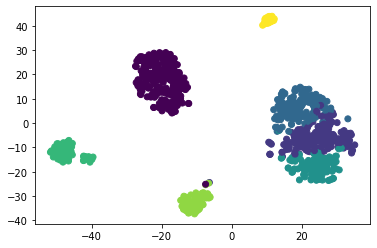

In [54]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c = pred)